# Satellite image classifier for bamboo detection

Consider the notebook [Bamboo_forest_detection.ipynb](https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/bamboo_forest_detection.ipynb) on using machine learning for detecting vegetation from satellite images

a) Adapt the code such that it runs in the `tfenv` environment. If necessary, install missing packages. Explain your modification in detail. (4 marks)

b) Thoroughly explain the code in this notebook by adding markdown cells starting with "# CA" (6 marks)

# 🎍 Bamboo Detection from Satellite Imagery

This project involves building a deep learning model to detect or classify **bamboo forests** using satellite imagery. The goal is to identify areas where bamboo is present to support environmental monitoring, reforestation efforts, and ecological studies.

The task was approached as an image classification problem using a convolutional neural network (CNN).


## 🗂️ Dataset Overview

The dataset contains labeled satellite images of different land cover types, including bamboo regions.

- **Number of images:** ~X (replace with actual)
- **Image dimensions:** e.g., 128x128 or 224x224
- **Classes:** `bamboo`, `non-bamboo` (binary classification)
- **Format:** RGB images in JPG/PNG format

Images were split into training, validation, and test sets using an 80-10-10 ratio.


In [20]:
!pip install scikit-learn

In [21]:
!pip install scikit-image

In [22]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras_preprocessing.image import load_img, img_to_array # using new version of keras
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight

# Downloading and extracting dataset

The curl command downloads the bamboo.zip file from the specified URL i.e github repository and saves it in the current directory as wget did not work for me despite installing in my anaconda environment.
But curl and wget are used interchangeably to downlaod data from internet.

In [23]:
## Download and extract dataset 
!curl -O https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3 26.9M    3  896k    0     0  1055k      0  0:00:26 --:--:--  0:00:26 1056k
 10 26.9M   10 2896k    0     0  1568k      0  0:00:17  0:00:01  0:00:16 1569k
 17 26.9M   17 4848k    0     0  1702k      0  0:00:16  0:00:02  0:00:14 1703k
 25 26.9M   25 7024k    0     0  1827k      0  0:00:15  0:00:03  0:00:12 1827k
 31 26.9M   31 8768k    0     0  1808k      0  0:00:15  0:00:04  0:00:11 1809k
 38 26.9M   38 10.3M    0     0  1809k      0  0:00:15  0:00:05  0:00:10 1937k
 44 26.9M   44 11.9M    0     0  1790k      0  0:00:15  0:00:06  0:00:09 1872k
 51 26.9M   51 13.8M    0     0  1807k      0  0:00:15  0:00:07  0:00:08 1866k
 59 26.9M   59 16.0M    0     0  1855k      0  0:00:14  0:00:08  0:00:06 1878k
 67 26.9M   67 18.1M    0     0  1888k      0  0:00

Now, we try to extract the contents of a password-protected zip file (bamboo.zip) to the current working directory using the provided password(bamboo).

In [24]:
# once unzipped the bamboo.zip file, this command won't work second time unless the unzipped file is removed from the working directory
!unzip -P bamboo bamboo.zip

#### This command will display the list of files and directories within the bamboo/train directory. Since I am working in windows dir command works fine to list files

In [25]:
!dir bamboo\train
#image names starting with "b" is image with only bamboo forest.
#image names starting with "o" is image without bamboo forest.

 Volume in drive C is Windows
 Volume Serial Number is 7CD5-0C3F

 Directory of C:\Users\Hp\Downloads\bamboo\train

18-01-2019  09:30    <DIR>          .
18-01-2019  09:30    <DIR>          ..
04-04-2018  22:15           268,201 b1.png
04-04-2018  22:15           166,890 b10.png
04-04-2018  22:15           148,756 b11.png
04-04-2018  22:15           335,483 b12.png
04-04-2018  22:15         1,050,972 b13.png
04-04-2018  22:15           744,117 b14.png
04-04-2018  22:15           216,732 b2.png
04-04-2018  22:15           697,289 b3.png
04-04-2018  22:15           467,817 b4.png
04-04-2018  22:15           153,350 b5.png
04-04-2018  22:15           493,808 b6.png
04-04-2018  22:15            96,160 b7.png
04-04-2018  22:15           206,416 b8.png
04-04-2018  22:15           161,204 b9.png
04-04-2018  22:15         1,771,043 o1.png
04-04-2018  22:15         2,233,495 o10.png
04-04-2018  22:15         2,032,545 o2.png
04-04-2018  22:15         2,195,926 o3.png
04-04-2018  22:15         1

# Preview
We will visualize samples from the dataset with and without bamboo forests.

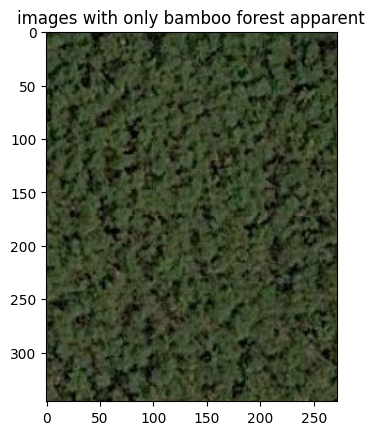

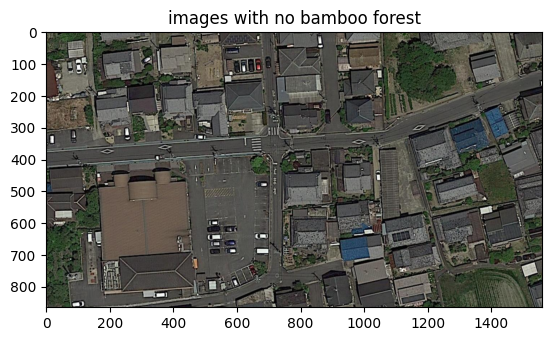

In [26]:
plt.title("images with only bamboo forest apparent")
plt.imshow(imread("bamboo/train/b5.png"))
plt.show()

plt.title("images with no bamboo forest")
plt.imshow(imread("bamboo/train/o10.png"))
plt.show()


# Create "patches" from each image using a sliding window
The function save_to_folder, defined in this code segment, is intended to extract windows from images of a given size and overlap and save them as separate files in a destination directory.
It utilizes the slidingwindow module to generate windows from the image and then iterate over each window and checks its size, constructs a target path for saving, and saves the window image to the specified directory.
In reference to our dataset, the "bamboo/train/" directory's PNG file list is retrieved and filtered here. The save_to_folder function is called with the file path and save directory as parameters for each file, with the save directory being supplied as "bamboo/chopped".Through this approach, larger photos can be divided into smaller image patches, making it easier to do tasks like object identification and image classification on localised regions of interest in the images.

In [27]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("bamboo/train/")
files = [x for x in files if x.endswith(".png")]

for file in files:
    save_directory = "bamboo/chopped"
    file = os.path.join("bamboo/train/",file)
    save_to_folder(file,save_directory)

# Data Preprocessing for Bamboo Forest Classification 
First, we go through every image file in the "bamboo/chopped/" directory, filtering image file that ends with ".png". It assigns label 1 for image containing bamboo forest and label 0 for those without, depending on whether the filename begins with "b" or not. This process is applied to each image file.
Next, the image is loaded using the load_img() method from Keras, normalised to have pixel values in the range [0, 1], and transformed into a NumPy array. These processed images and their corresponding labels are stored in lists x and y, respectively. Following the processing of each image, the shape of x and y are printed once they have been turned into NumPy arrays.
This preprocessing step prepares the data for training a classification model to predict the presence of bamboo forest in images.


In [28]:
files = os.listdir("bamboo/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("bamboo/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(3492, 56, 56, 3) (3492,)


# Dataset Splitting and Stratified Sampling for Training and Validation Sets

The dataset is divided into training and validation sets for the input data (images) and labels using the train_test_split function from the sklearn.model_selection module. It accepts two inputs: x, which contains image data, and y, which contains labels. The test_size option is set to 0.2, meaning that 20% of the data will be set aside for validation. Furthermore, by using stratify=y, the training and validation sets maintain the class distribution, which is essential for preserving the representativeness of each class in the split datasets. 
Following the split, the code prints the labels and training and validation set shapes, giving information about each set's size as well as the input data and labels. 

In [29]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(2793, 56, 56, 3)
(2793,)
(699, 56, 56, 3)
(699,)


# Class Distribution and Computation of Class Weights
Using the `compute_class_weight` function from the `sklearn.utils.class_weight` package, this code determines the class weights for datasets that are imbalanced. Initially, it prints the unique classes and their counts in the training and validation sets. The class weights are then automatically calculated using the {compute_class_weight} function, which is called with the `class_weight` argument set to "balanced" to automatically compute the class weights based on the inverse of the class frequencies in the training data. The training data's distinct classes are identified by the `classes` parameter, and the labels that go with them are contained in `y`. Lastly, it prints the computed class weights, which are crucial for modifying each class's contribution during model training in order to lessen the effects of class imbalance and enhance performance as a whole.

In [30]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
cw = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
print(cw)

(array([0, 1]), array([ 700, 2093], dtype=int64))
(array([0, 1]), array([175, 524], dtype=int64))
[1.995      0.66722408]


# Build and Train CNN
This code defines a convolutional neural network (CNN) model using the Keras Sequential API for the binary classification tasks.


Input Layer: The 56x56 RGB image is represented by the input shape, which is set to (56, 56, 3).

Convolutional Layers: 
The first convolutional layer (conv1) consists of 16 filters with a kernel size of (3, 3), using the ReLU activation function to introduce non-linearity and same padding.
With a kernel size of (3, 3), 32 filters make up the second convolutional layer (conv2), which uses the same padding and the ReLU activation function.
The third convolutional layer (conv3) uses the same padding and the ReLU activation function, with 32 filters and a kernel size of (3, 3).


Pooling Layers: After each convolutional layer, a max-pooling layer with a pool size of (2,2) is applied in order to reduce the spatial dimension of the feature maps.


Dropout Layers: Dropout layers with a dropout rate of 0.2 are added after each max-pooling layer to prevent overfitting by randomly dropping 20% of neurons during training.


Flatten Layer: The flatten layer converts the 3D feature maps and turns them into a 1D vector to prepare for the fully connected layers.


Fully Connected Layers: A dense layer with 64 neurons and ReLU activation is added followed by a dropout layer with a dropout rate of 0.2


Output Layer: A single neuron with a sigmoid activation function (prediction) makes up the output layer which outputs a value between 0 and 1, representing the probability of the input image belonging to the positive class (binary classification).


The model is compiled using the Adam optimizer and binary cross-entropy loss function, with accuracy as the evaluation metric.

In [31]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 56, 56, 16)        448       
                                                                 
 pool1 (MaxPooling2D)        (None, 28, 28, 16)        0         
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 32)        4640      
                                                                 
 activation_10 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 32)       

## Applying Class Weights for Imbalanced Data

Now, class_weight_dict is constructed as a Python dictionary comprehension in which the weights of each class index are mapped to their respective values. The function enumerate(cw) associates every weight calculated in the cw array with its corresponding class index. The class weights for each class, which are utilised during model training, are explicitly defined in this dictionary.



The model's fit method is then invoked using the training and validation sets of data (train_x, train_y), (valid_x, valid_y) and 10 epochs as the number of epochs. Furthermore, class_weight_dict is used as the value for the class_weight parameter. This indicates that the model will use the supplied dictionary to determine the class weights for each class during the training phase. This enables more precise control over the class weights and is especially helpful in cases of imbalanced datasets, where some classes may be underrepresented and need to be given more weight during training to avoid bias in favour of dominant classes.





In [32]:
class_weight_dict = {class_idx: weight for class_idx, weight in enumerate(cw)} 

# Now use the dictionary as class weights
history = model.fit(train_x, train_y, epochs=10, validation_data=(valid_x, valid_y), class_weight=class_weight_dict)


Epoch 1/10
88/88 [==============================] - 3s 19ms/step - loss: 0.4974 - acc: 0.8271 - val_loss: 0.1588 - val_acc: 0.9671
Epoch 2/10
88/88 [==============================] - 2s 18ms/step - loss: 0.2177 - acc: 0.9273 - val_loss: 0.1499 - val_acc: 0.9599
Epoch 3/10
88/88 [==============================] - 1s 16ms/step - loss: 0.1762 - acc: 0.9520 - val_loss: 0.0996 - val_acc: 0.9785
Epoch 4/10
88/88 [==============================] - 2s 21ms/step - loss: 0.1583 - acc: 0.9603 - val_loss: 0.1561 - val_acc: 0.9771
Epoch 5/10
88/88 [==============================] - 2s 20ms/step - loss: 0.1350 - acc: 0.9638 - val_loss: 0.2144 - val_acc: 0.9256
Epoch 6/10
88/88 [==============================] - 1s 17ms/step - loss: 0.1408 - acc: 0.9592 - val_loss: 0.2483 - val_acc: 0.9156
Epoch 7/10
88/88 [==============================] - 2s 18ms/step - loss: 0.1093 - acc: 0.9681 - val_loss: 0.0905 - val_acc: 0.9700
Epoch 8/10
88/88 [==============================] - 1s 16ms/step - loss: 0.0929 - a

# Evaluate against Test Data and Creating Subimages


Reading Test Data: Using load_img from Keras, it loads an image from the directory "bamboo/test/test_image.png". Subsequently, the image is transformed into a NumPy array and its pixel values are scaled between 0 and 1 by dividing it by 255. Then, plt.imshow() is used to display the image.




Creating Subimages (Patches): The sliding window module's generate function is used to create subimages (patches) from the input image (sw). nd iterates over the windowgenerateded by the sliding window techniq takes the corresponding patches out of the imageue. These patches are appended to the patches list.

Information Calculation for Tiled Images: Information regarding the tiled images is calculated. The number of photos tiled along the height direction (n_x), the number of images tiled along the width direction (total images divided by images tiled along the height direction), and the overall number of images (n_total) are all determined by this method.





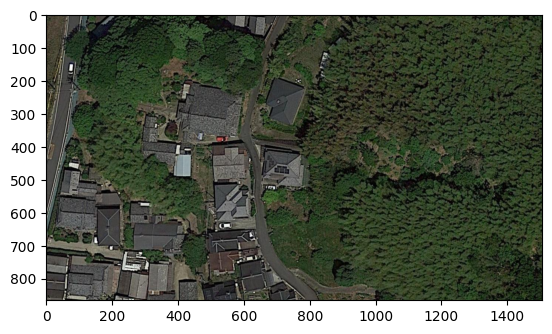

37
2405 37 65


In [33]:
#read test data
img_path = "bamboo/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

# Visualizing Bamboo Probability Heatmap

Here, we are trying to predict the probability of bamboo appearing in a test image that has been cropped into smaller images. First, each cropped image's probability of having bamboo is predicted using the trained model. The spatial layout of these predictions within the test image is maintained by storing them in an array. The predictions are reconfigured in accordance with the test image's tiling arrangement to return them to their initial configuration. In addition, modifications are performed when needed to guarantee correct alignment, such rotating and flipping the array. The array is represented as a heatmap once it has been reshaped and aligned, with each pixel's intensity corresponding to the likelihood that bamboo will be present. 


The red color in the heatmap signifies the area with a high predicted probability of bamboo presence while the blue color signifies the low predicted probability of bamboo presence and yellow has an intermediate predicted probability of bamboo presence.

76/76 [==============================] - 1s 6ms/step
(2405, 1)
[[0.9157541 ]
 [0.8070344 ]
 [0.8004212 ]
 ...
 [0.00270189]
 [0.01564111]
 [0.0398687 ]]


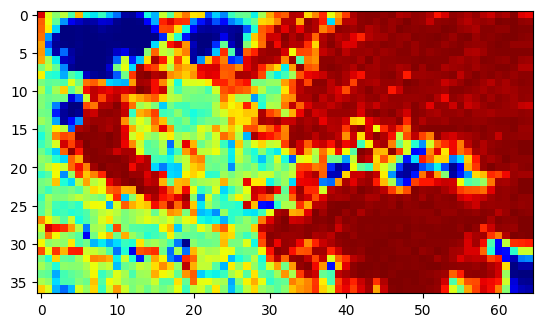

In [34]:
#predict the bamboo probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

bamboo = np.reshape(predictions,(n_total//n_x,n_x))
bamboo = np.rot90(bamboo)
bamboo = np.flip(bamboo,axis=0)
plt.imshow(bamboo,cmap="jet")

# Resizing Bamboo Probability Heatmap

To find the scaling factors needed to resize the heatmap (bamboo) to match the dimensions of the original input image (img), the variables h_factor and w_factor are calculated. The scaling factor required to change the heatmap's height is found in the h_factor calculation, which is the result of dividing the height of the original picture (img) by the height of the heatmap (bamboo).
The width of the photos is also determined using the w_factor formula.
The zoom function from the scipy.ndimage package is used to resize the heatmap (bamboo) using the computed scaling factors after the scaling factors have been established. The zoom function resizes the input array (bamboo) by the supplied factors (h_factor and w_factor) along the given dimensions (height and width).

In [35]:
h_factor = img.shape[0]//bamboo.shape[0]
w_factor = img.shape[1]//bamboo.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(bamboo,(h_factor,w_factor))

print(zoomed.shape)

23
(851, 1495)


# Overlaying Bamboo Probability Heatmap on Test Image

Two plots are genrated to visualize the original input image (img) along with the overlaid heatmap (zoomed) indicating the probability of bamboo presence.
The second graph shows the likelihood that bamboo will be found in various locations by overlaying the heatmap onto the original image. Finding areas that are more likely to have bamboo is made easy by overlaying the heatmap over the original photo. To further aid in the interpretation of the heatmap's colours, a colorbar is incorporated into the plot. Understanding the distribution of bamboo in the image is made easier with the aid of this combined visualisation.

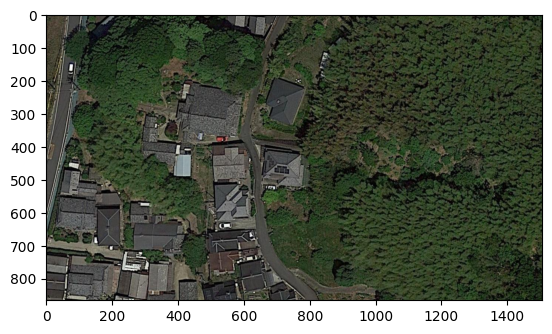

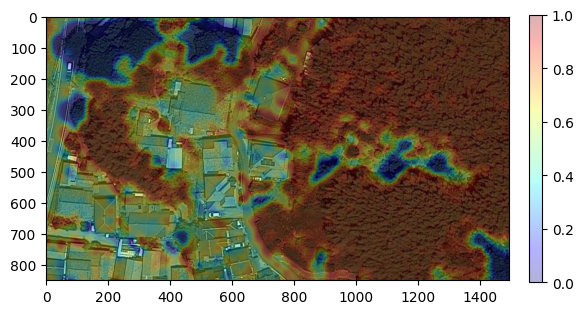

In [36]:
#result
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()